In [1]:
# general
import numpy as np
from numpy.random import PCG64, SeedSequence
import pandas as pd
import verde as vd
import xarray as xr
import skgstat as skg
from skgstat import models
import gstatsim as gsm
from scipy.interpolate import RBFInterpolator
from scipy.stats import qmc
from sklearn.preprocessing import QuantileTransformer
from tqdm.auto import tqdm
import multiprocessing as mp

# plotting
import matplotlib.pyplot as plt
from cmcrameri import cm

# io
from tqdm.auto import tqdm
import os
from pathlib import Path
import time
import numbers
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('..')

import gstatsim_custom as gsim

In [2]:
ds = xr.open_dataset(Path('../../bedmap/bedmap3_mod_500m.nc'))

# exposed_rock_cond = np.full(ds.thick_cond.shape, np.nan)
# exposed_rock_cond[ds.mask == 4] = True
thick_cond = np.where(ds.mask == 4, 0, ds.thick_cond.values)
#ground_ice_msk = ds.mask==1

bed_cond = ds.surface_topography.values - thick_cond
ice_rock_msk = (ds.mask == 1) | (ds.mask == 4) | (ds.mask == 2)
bed_cond = np.where(ice_rock_msk, bed_cond, np.nan)
xx, yy = np.meshgrid(ds.x, ds.y)

cond_msk = ~np.isnan(bed_cond)
#cond_msk = np.where(
x_cond = xx[cond_msk]
y_cond = yy[cond_msk]
data_cond = bed_cond[cond_msk]
trend = ds.trend.values

res_cond = bed_cond - trend

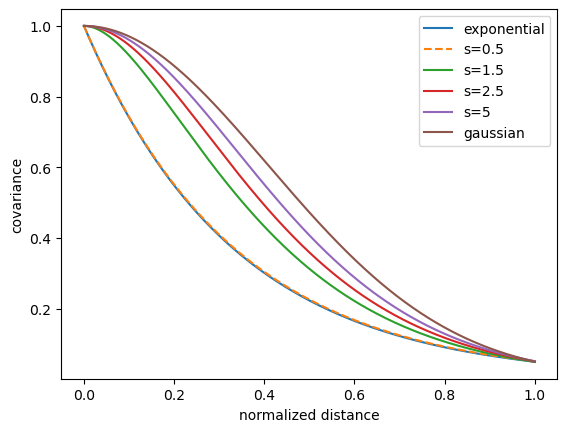

In [3]:
xi = np.linspace(0, 1, 1000)
yi0 = gsim.covariance.exponential_cov_norm(xi, sill=1.0, nugget=0)
yi1 = gsim.covariance.matern_cov_norm(xi, sill=1.0, nugget=0, s=0.5)
yi2 = gsim.covariance.matern_cov_norm(xi, sill=1.0, nugget=0, s=1.5)
yi3 = gsim.covariance.matern_cov_norm(xi, sill=1.0, nugget=0, s=2.5)
yi4 = gsim.covariance.matern_cov_norm(xi, sill=1.0, nugget=0, s=5)
yi5 = gsim.covariance.gaussian_cov_norm(xi, sill=1.0, nugget=0)

plt.plot(xi, yi0, label='exponential')
plt.plot(xi, yi1, '--', label='s=0.5')
plt.plot(xi, yi2, label='s=1.5')
plt.plot(xi, yi3, label='s=2.5')
plt.plot(xi, yi4, label='s=5')
plt.plot(xi, yi5, label='gaussian')
plt.xlabel('normalized distance')
plt.ylabel('covariance')
plt.legend()
plt.show()

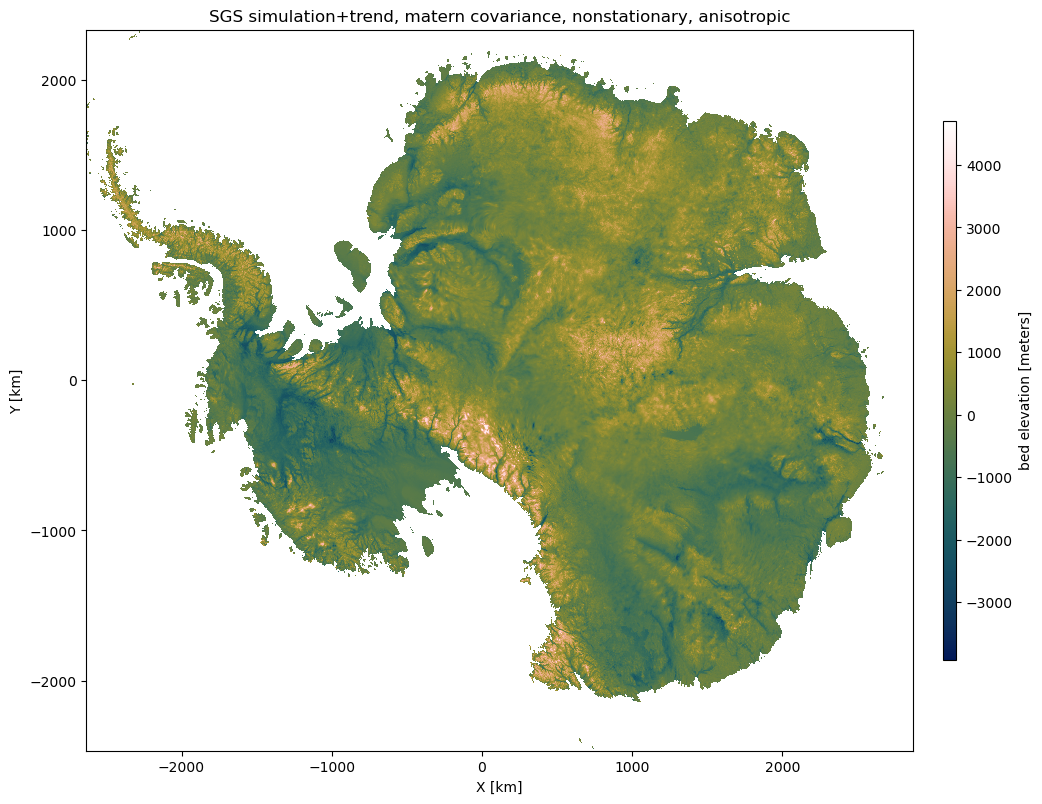

In [6]:
sim = np.load(Path('../../gstatsim_custom/results/nonstationary_sim_500m.npy'))

ilow = 2000
ihigh = 11600
jlow = 1400
jhigh = 12400

xx_trim = xx[ilow:ihigh,jlow:jhigh]
yy_trim = yy[ilow:ihigh,jlow:jhigh]
sim_trim = sim[ilow:ihigh,jlow:jhigh]
trend_trim = trend[ilow:ihigh,jlow:jhigh]

plt.figure(figsize=(13,10))
im = plt.pcolormesh(xx_trim/1000, yy_trim/1000, sim_trim+trend_trim, cmap=cm.batlowW)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('SGS simulation+trend, matern covariance, nonstationary, anisotropic')
plt.colorbar(im, pad=0.03, aspect=40, shrink=0.7, label='bed elevation [meters]')
plt.savefig('figures/matern_nonstationary.png', dpi=300, bbox_inches='tight')
plt.show()

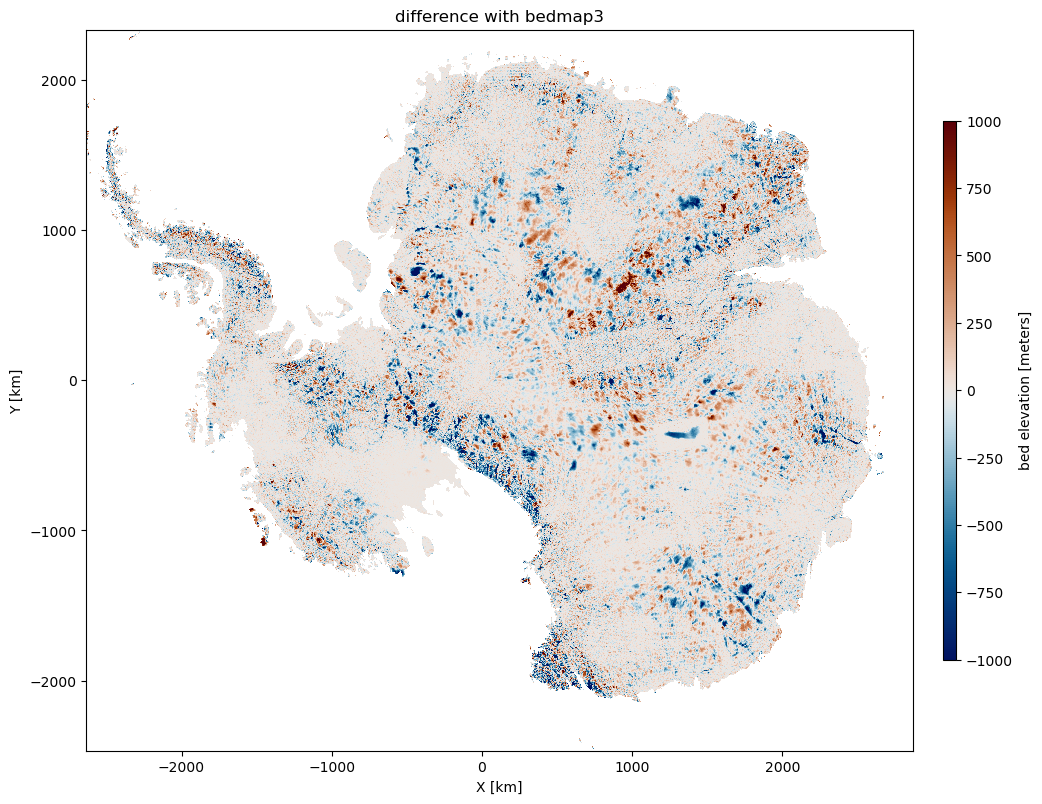

In [5]:
plt.figure(figsize=(13,10))
im = plt.pcolormesh(xx_trim/1000, yy_trim/1000, ds.bed_topography[ilow:ihigh,jlow:jhigh]-(sim_trim+trend_trim), cmap=cm.vik, vmin=-1000, vmax=1000)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('difference with bedmap3')
plt.colorbar(im, pad=0.03, aspect=40, shrink=0.7, label='bed elevation [meters]')
plt.show()

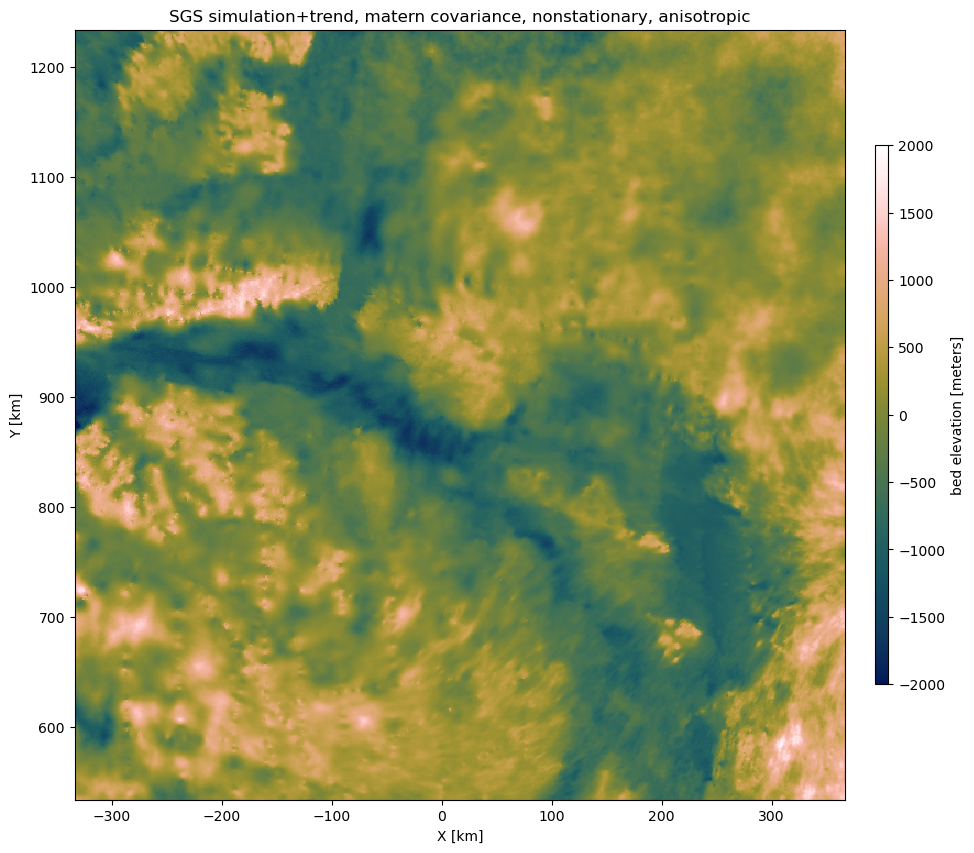

In [6]:
ilow = 2100
ihigh = 2800
jlow = 3000
jhigh = 3700

xx_trim = xx[ilow:ihigh,jlow:jhigh]
yy_trim = yy[ilow:ihigh,jlow:jhigh]
sim_trim = sim[ilow:ihigh,jlow:jhigh]
trend_trim = trend[ilow:ihigh,jlow:jhigh]

plt.figure(figsize=(13,10))
im = plt.pcolormesh(xx_trim/1000, yy_trim/1000, sim_trim+trend_trim, cmap=cm.batlowW, vmin=-2000, vmax=2000)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('SGS simulation+trend, matern covariance, nonstationary, anisotropic')
plt.colorbar(im, pad=0.03, aspect=40, shrink=0.7, label='bed elevation [meters]')
plt.show()

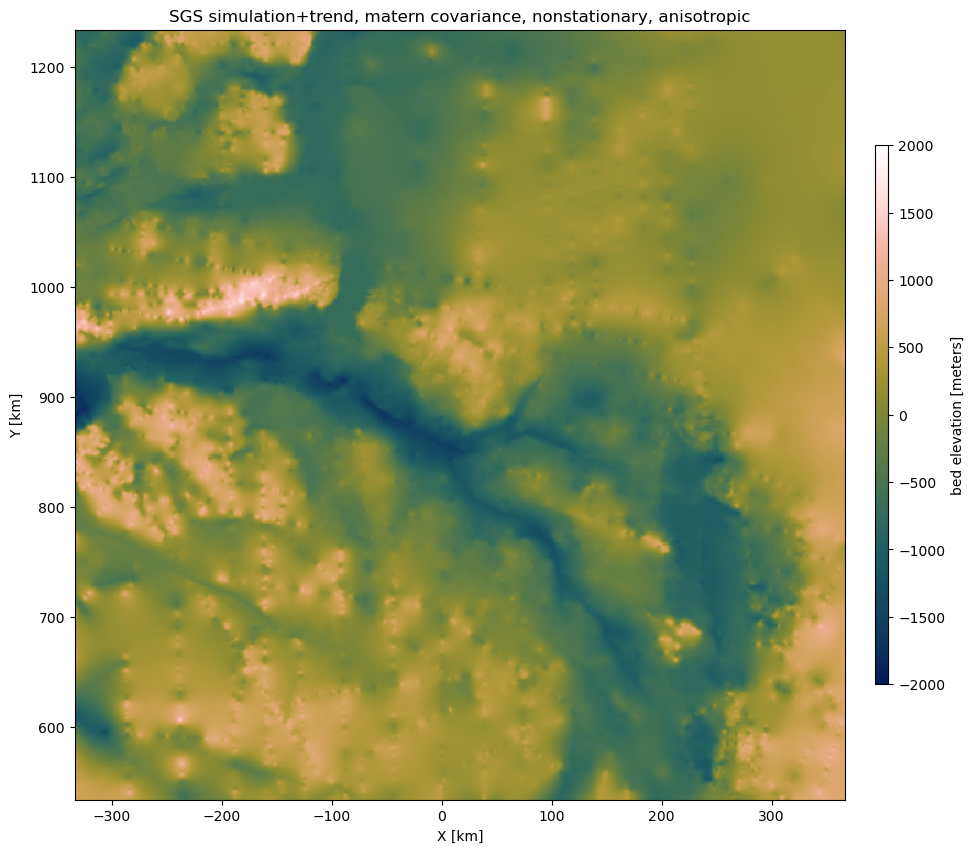

In [7]:
xx_trim = xx[ilow:ihigh,jlow:jhigh]
yy_trim = yy[ilow:ihigh,jlow:jhigh]
sim_trim = sim[ilow:ihigh,jlow:jhigh]
trend_trim = trend[ilow:ihigh,jlow:jhigh]

plt.figure(figsize=(13,10))
im = plt.pcolormesh(xx_trim/1000, yy_trim/1000, ds.bed_topography[ilow:ihigh,jlow:jhigh], cmap=cm.batlowW, vmin=-2000, vmax=2000)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('SGS simulation+trend, matern covariance, nonstationary, anisotropic')
plt.colorbar(im, pad=0.03, aspect=40, shrink=0.7, label='bed elevation [meters]')
plt.show()

In [8]:
np.nanmax(bed_cond)

np.float64(4604.0)

In [9]:
ds = xr.open_dataset(Path('../../bedmap/bedmap3_mod_1km.nc'))
ds = ds.sel(x=slice(-0.3e6, 0.3e6), y=slice(1.2e6, 0.5e6))
ds

<xarray.Dataset> Size: 30MB
Dimensions:                 (y: 701, x: 601)
Coordinates:
  * x                       (x) float32 2kB -3e+05 -2.99e+05 ... 2.99e+05 3e+05
  * y                       (y) float32 3kB 1.2e+06 1.199e+06 ... 5.01e+05 5e+05
Data variables: (12/13)
    surface_topography      (y, x) float32 2MB ...
    bed_uncertainty         (y, x) float32 2MB ...
    bed_topography          (y, x) float32 2MB ...
    mask                    (y, x) float64 3MB ...
    ice_thickness           (y, x) float32 2MB ...
    thickness_survey_count  (y, x) float32 2MB ...
    ...                      ...
    mapping                 <U19 76B ...
    geoid                   (y, x) float64 3MB ...
    bed_ell                 (y, x) float64 3MB ...
    surface_ell             (y, x) float64 3MB ...
    thick_cond              (y, x) float64 3MB ...
    trend                   (y, x) float64 3MB ...
Attributes: (12/26)
    crs:                    EPSG:3031
    title:                  BEDMAP3 - Ice thickness, bed and surface elevatio...
    summary:                We present here Bedmap3, the latest suite of grid...
    keywords:               Antarctica,BEDMAP,Elevation,Ice thickness
    Conventions:            ACDD-1.3, CF-1.8
    citation:               Pritchard, H., Fretwell, P., Fremand, A., Bodart,...
    ...                     ...
    time_coverage_end:      2024-11-01
    geospatial_lon_min:     -180
    geospatial_lon_max:     180
    geospatial_lat_min:     -90
    geospatial_lat_max:     -60
    geospatial_bounds_crs:  EPSG:4326

In [10]:
sim = np.load(Path('results/partial_nonstationary_sim.npy'))
sim.shape

(701, 601)

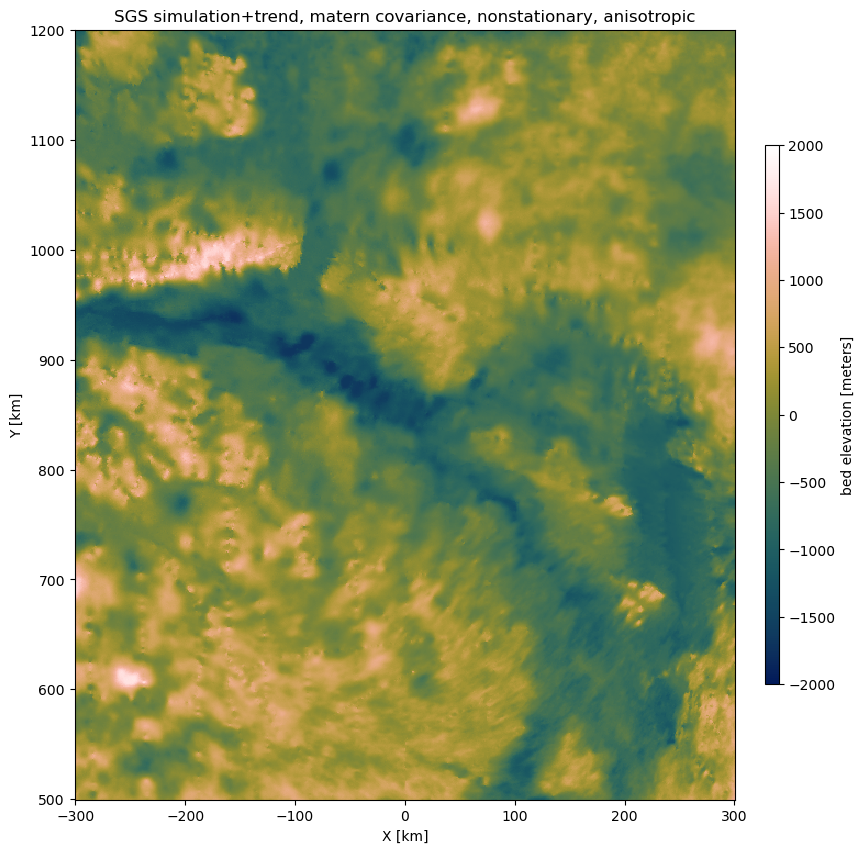

In [11]:
plt.figure(figsize=(13,10))
im = plt.pcolormesh(ds.x/1000, ds.y/1000, sim+ds.trend, cmap=cm.batlowW, vmin=-2000, vmax=2000)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.title('SGS simulation+trend, matern covariance, nonstationary, anisotropic')
plt.colorbar(im, pad=0.03, aspect=40, shrink=0.7, label='bed elevation [meters]')
plt.show()

In [12]:
ds

<xarray.Dataset> Size: 30MB
Dimensions:                 (y: 701, x: 601)
Coordinates:
  * x                       (x) float32 2kB -3e+05 -2.99e+05 ... 2.99e+05 3e+05
  * y                       (y) float32 3kB 1.2e+06 1.199e+06 ... 5.01e+05 5e+05
Data variables: (12/13)
    surface_topography      (y, x) float32 2MB ...
    bed_uncertainty         (y, x) float32 2MB ...
    bed_topography          (y, x) float32 2MB ...
    mask                    (y, x) float64 3MB ...
    ice_thickness           (y, x) float32 2MB ...
    thickness_survey_count  (y, x) float32 2MB ...
    ...                      ...
    mapping                 <U19 76B ...
    geoid                   (y, x) float64 3MB ...
    bed_ell                 (y, x) float64 3MB ...
    surface_ell             (y, x) float64 3MB ...
    thick_cond              (y, x) float64 3MB ...
    trend                   (y, x) float64 3MB ...
Attributes: (12/26)
    crs:                    EPSG:3031
    title:                  BEDMAP3 - Ice thickness, bed and surface elevatio...
    summary:                We present here Bedmap3, the latest suite of grid...
    keywords:               Antarctica,BEDMAP,Elevation,Ice thickness
    Conventions:            ACDD-1.3, CF-1.8
    citation:               Pritchard, H., Fretwell, P., Fremand, A., Bodart,...
    ...                     ...
    time_coverage_end:      2024-11-01
    geospatial_lon_min:     -180
    geospatial_lon_max:     180
    geospatial_lat_min:     -90
    geospatial_lat_max:     -60
    geospatial_bounds_crs:  EPSG:4326

In [13]:
import geopandas as gpd

In [14]:
pts = gpd.read_file(Path(r'D:\bm3_streamlines_pt\bm3_streamlines_pt.shp'))
pts

thick  streamln  streampt                   geometry
0         566      1218    211192  POINT (-1236750 -1096250)
1         534      1218    211193  POINT (-1236250 -1096250)
2        2010      1213    211194  POINT (-1102750 -1096250)
3        1994      1213    211195  POINT (-1102250 -1096250)
4         859      1199    211196  POINT (-1046750 -1096250)
...       ...       ...       ...                        ...
258716    862      3087      6167     POINT (686750 1976250)
258717    861      3087      6168     POINT (687250 1976250)
258718    693      4741      6169     POINT (778250 1976250)
258719    520      4740      6170     POINT (808750 1976250)
258720    514      4740      6171     POINT (809250 1976250)

[258721 rows x 4 columns]

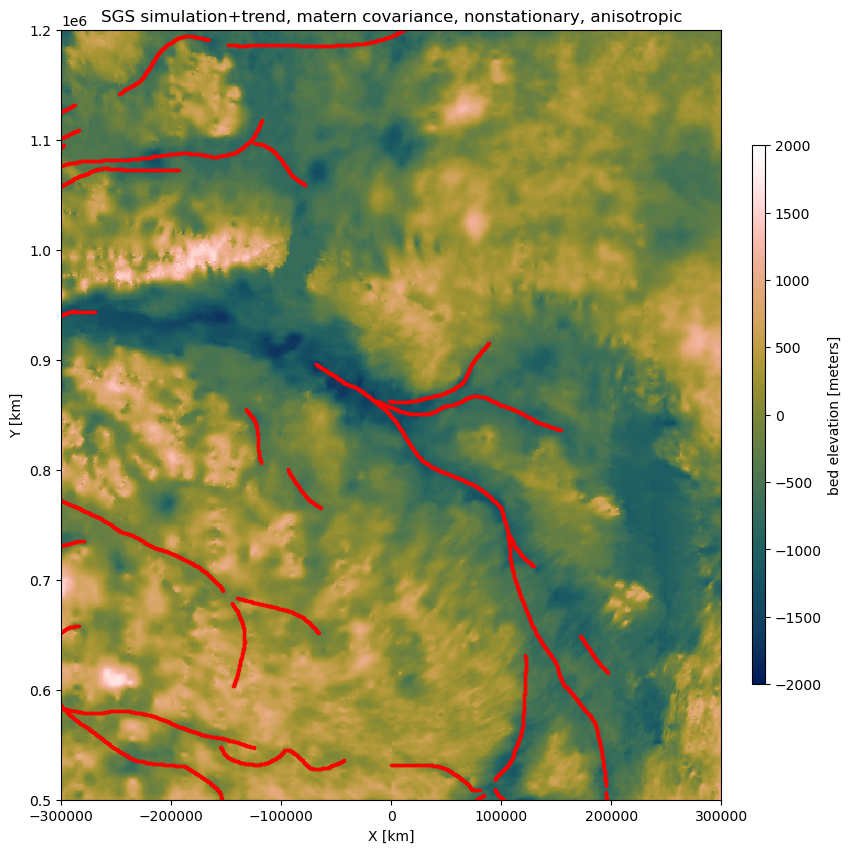

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(13,10))
im = ax.pcolormesh(ds.x, ds.y, sim+ds.trend, cmap=cm.batlowW, vmin=-2000, vmax=2000)
pts.plot(c='r', ax=ax, markersize=2)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_xlim(ds.x.min(), ds.x.max())
ax.set_ylim(ds.y.min(), ds.y.max())
ax.set_title('SGS simulation+trend, matern covariance, nonstationary, anisotropic')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, shrink=0.7, label='bed elevation [meters]')
plt.show()

In [18]:
import bisect

def xy_into_grid_new(gridx, gridy, coords, values, fill=np.nan, ydim=0, xdim=1):
    """
    Place tabular data that is colocated with grid coordinates inside of grid.

    Args:
        ds : xarray.Dataset with grid coordinates
        coords : tuple of tabular coordinates, e.g., (x, y)
        values : tuple of values correspondin to coords, e.g., (var1, var2)
        fill : value to fill in grid where there are no values
        ydim : int corresponding to axis representing y-dimension in grid
        xdim : int corresponding to axis representing x-dimension in grid
    Outputs:
        if multiple arrays in values, returns a tuple of gridded values, 
        otherwise returns single gridded array
    """
    if gridx[0] > gridx[1]:
        gridx = np.sort(gridx)
        reversex = True
    else:
        reversex = False
    if gridy[0] > gridy[1]:
        gridy = np.sort(gridy)
        reversey = True
    else:
        reversey = False
    
    values = np.array(values)
    if len(values.shape)==1:
        values = np.expand_dims(values, axis=0)
        
    arr = np.full((len(values), len(gridy), len(gridx)), fill)
    
    for i in range(len(coords[0])):
        xi = coords[0][i]
        yi = coords[1][i]
        xind = bisect.bisect_left(gridx, xi)
        yind = bisect.bisect_left(gridy, yi)
        if (xind < len(gridx)) & (yind < len(gridy)):
            if (gridx[xind] == xi) & (gridy[yind] == yi):
                if reversex == True:
                    xind = len(gridx) - xind - 1
                if reversey == True:
                    yind = len(gridy) - yind - 1
                arr[:,yind, xind] = values[:,i].squeeze()
    if arr.shape[0]>1:
        return tuple(arr)
    else:
        return arr.squeeze()

In [19]:
ds2 = xr.open_dataset(Path('../bedmap/bedmap3_mod.nc'))

In [20]:
xmin = ds.x.min().values
xmax = ds.x.max().values
ymin = ds.y.min().values
ymax = ds.y.max().values

whole_coords = pts.get_coordinates().to_numpy()

msk = (whole_coords[:,0] > xmin) & (whole_coords[:,0] < xmax) & (whole_coords[:,1] > ymin) & (whole_coords[:,1] < ymax)
pts_trim = pts[msk==True]
pts_trim.shape

(6962, 4)

In [21]:
ds2 = ds2.sel(x=slice(-0.3e6, 0.3e6), y=slice(1.2e6, 0.5e6))
xx, yy = np.meshgrid(ds2.x, ds2.y)
#grid = np.full(xx.shape, np.nan)
grid = np.zeros(xx.shape)

for streamid in tqdm(pts_trim.streamln.unique()):
    stream = pts_trim.loc[pts_trim.streamln==streamid]
    coords = stream.get_coordinates()
    coords = (np.rint(coords['x'].values), np.rint(coords['y'].values))
    thick = stream.thick.values
    # dist_msk = vd.distance_mask((pred_coords[:,0], pred_coords[:,1]), 10e3, (xx.flatten(), yy.flatten()))
    grid += xy_into_grid_new(ds2.x.values, ds2.y.values, coords, thick, fill=0)

grid = np.where(grid == 0, np.nan, grid)

  0%|          | 0/76 [00:00<?, ?it/s]

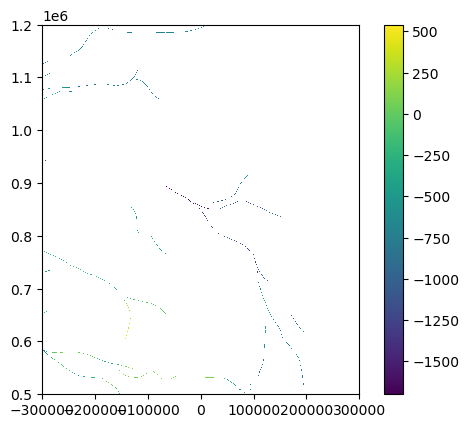

In [22]:
plt.pcolormesh(ds2.x, ds2.y, ds2.surface_topography-grid)
plt.axis('scaled')
plt.colorbar()
plt.show()

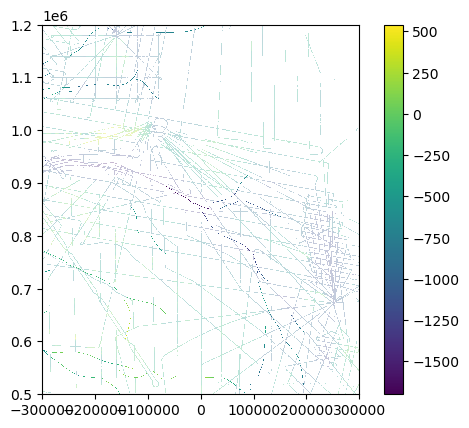

In [23]:
plt.pcolormesh(ds2.x, ds2.y, ds2.surface_topography-ds2.thick_cond, alpha=0.3)
plt.pcolormesh(ds2.x, ds2.y, ds2.surface_topography-grid)
plt.axis('scaled')
plt.colorbar()
plt.show()

In [40]:
coords = pts_trim.get_coordinates()
coords = (np.rint(coords['x'].values), np.rint(coords['y'].values))
thick = pts_trim.thick.values

xx, yy = np.meshgrid(ds.x, ds.y)

dist_msk = vd.distance_mask(coords, 1e3, (xx, yy))

kn = vd.KNeighbors(k=1)
kn.fit(coords, thick)
preds = kn.predict((xx[dist_msk], yy[dist_msk]))

stream_thick = np.full(xx.shape, np.nan)
np.place(stream_thick, dist_msk, preds)

In [41]:
stream_bed = ds.surface_topography.values - stream_thick
sim_bed = sim + ds.trend.values

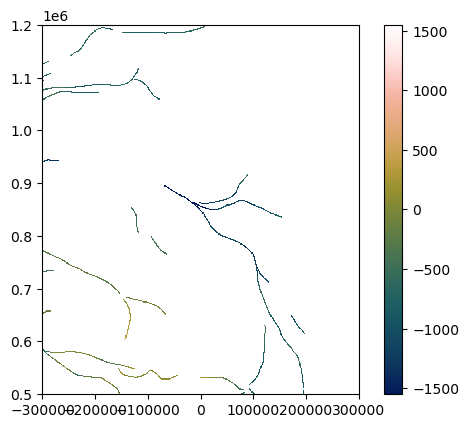

In [42]:
plt.pcolormesh(ds.x, ds.y, stream_bed, cmap=cm.batlowW, vmin=-1550, vmax=1550)
plt.axis('scaled')
plt.colorbar()
plt.show()

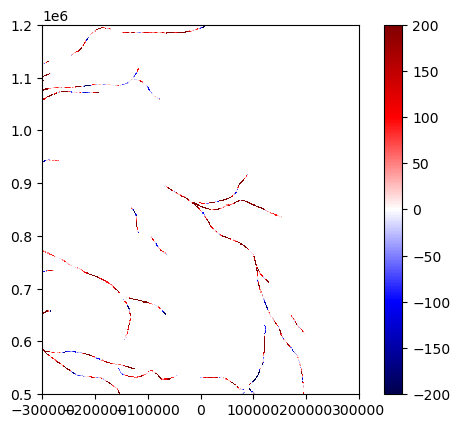

In [27]:
plt.pcolormesh(ds.x, ds.y, sim_bed-stream_bed, cmap='seismic', vmin=-200, vmax=200)
plt.axis('scaled')
plt.colorbar()
plt.show()

In [28]:
from scipy.interpolate import RBFInterpolator

residual = sim_bed-stream_bed

preds = RBFInterpolator(np.array([xx[dist_msk], yy[dist_msk]]).T, residual[~np.isnan(residual)], epsilon=1e-10)(np.array([xx.flatten(), yy.flatten()]).T)
preds.shape

(421301,)

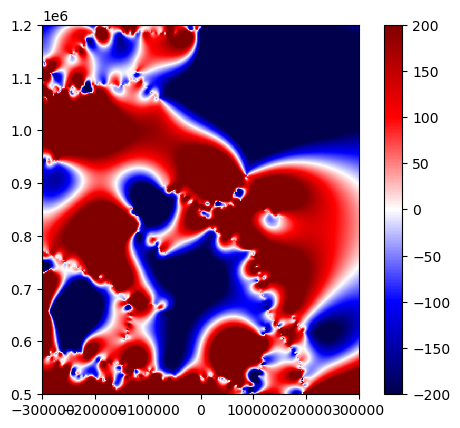

In [29]:
plt.pcolormesh(ds.x, ds.y, preds.reshape(xx.shape), cmap='seismic', vmin=-200, vmax=200)
plt.axis('scaled')
plt.colorbar()
plt.show()

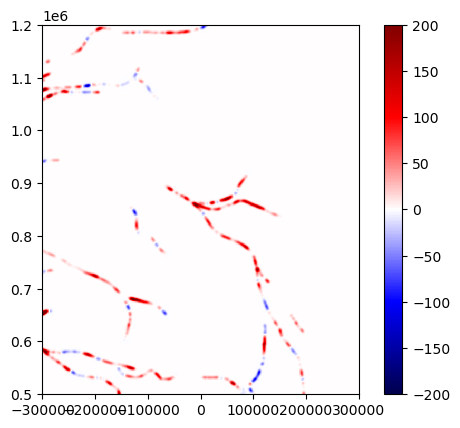

In [30]:
from skimage.filters import gaussian

filt = gaussian(np.where(np.isnan(residual), 0, residual), sigma=2, preserve_range=True)

plt.pcolormesh(ds.x, ds.y, filt, cmap='seismic', vmin=-200, vmax=200)
plt.axis('scaled')
plt.colorbar()
plt.show()

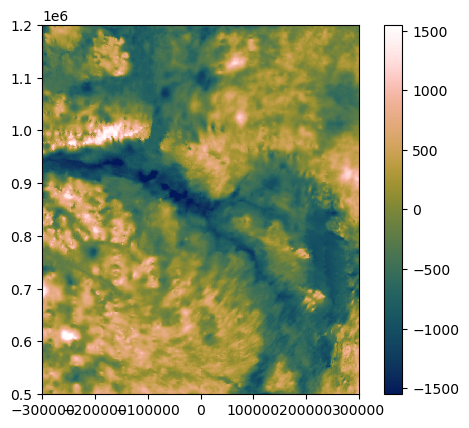

In [31]:
plt.pcolormesh(ds.x, ds.y, sim_bed-filt, cmap=cm.batlowW, vmin=-1550, vmax=1550)
plt.axis('scaled')
plt.colorbar()
plt.show()

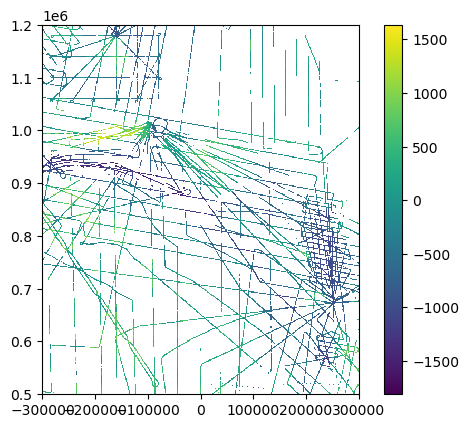

In [32]:
plt.pcolormesh(ds.x, ds.y, ds.surface_topography-ds.thick_cond)
plt.axis('scaled')
plt.colorbar()
plt.show()

In [34]:
xx, yy = np.meshgrid(ds2.x, ds2.y)
tmp_msk = np.full(xx.shape, False)
tmp_msk[400:600,400:600] = True

coords_tmp = (xx[tmp_msk], yy[tmp_msk])
values = ds2.bed_topography.values[tmp_msk]

fill_grid = xy_into_grid_new(ds2.x.values, ds2.y.values, coords_tmp, values)
#fill_gird = xy_into_grid(ds2, coords_tmp, values)

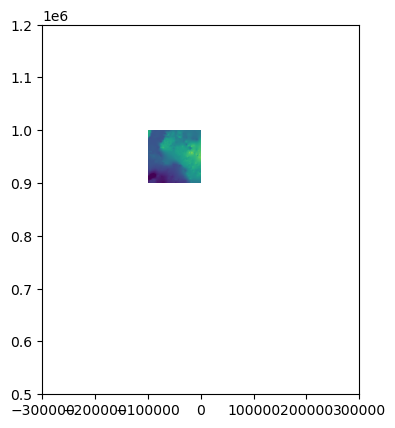

In [35]:
plt.pcolormesh(ds2.x, ds2.y, fill_grid, vmin=-1500, vmax=1500)
plt.axis('scaled')
plt.show()

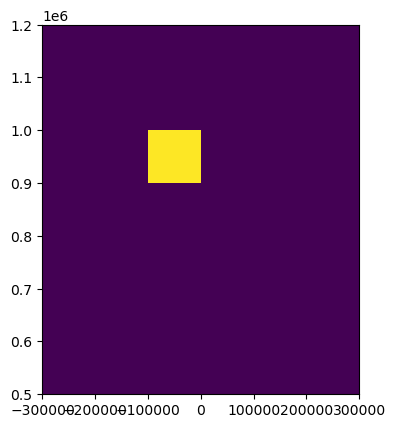

In [36]:
tmp = np.where(fill_grid == ds2.bed_topography.values, True, False)
plt.pcolormesh(ds2.x, ds2.y, tmp)
plt.axis('scaled')
plt.show()

In [37]:
np.allclose(tmp, tmp_msk)

True

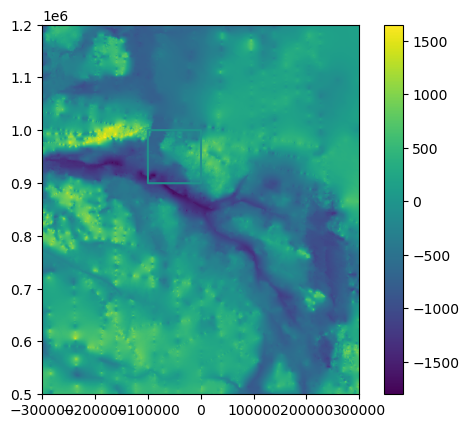

In [38]:
im = plt.pcolormesh(ds2.x, ds2.y, ds2.bed_topography)
plt.contour(ds2.x, ds2.y, tmp_msk, levels=[0], vmin=-1500, vmax=1500)
plt.axis('scaled')
plt.colorbar(im)
plt.show()

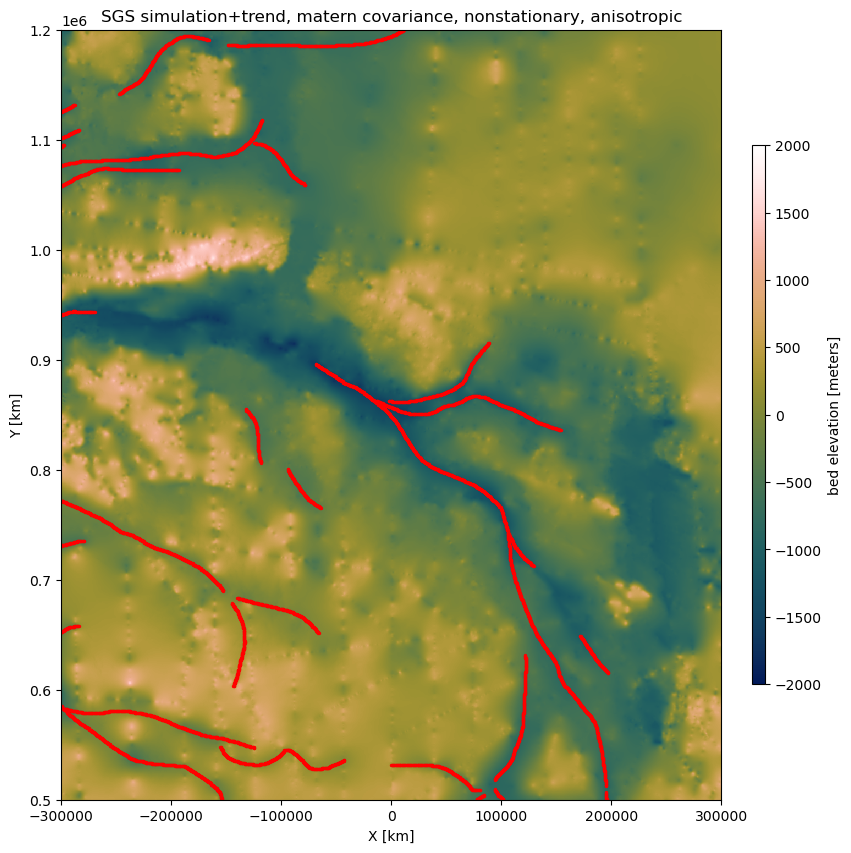

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(13,10))
im = ax.pcolormesh(ds2.x, ds2.y, ds2.bed_topography, cmap=cm.batlowW, vmin=-2000, vmax=2000)
pts_trim.plot(c='r', ax=ax, markersize=2)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_xlim(ds.x.min(), ds.x.max())
ax.set_ylim(ds.y.min(), ds.y.max())
ax.set_title('SGS simulation+trend, matern covariance, nonstationary, anisotropic')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, shrink=0.7, label='bed elevation [meters]')
plt.show()

In [103]:
ds2.x.values

array([-299750., -299250., -298750., ...,  298750.,  299250.,  299750.],
      dtype=float32)

In [43]:
ds = xr.open_dataset(Path('../../bedmap/bedmap3_mod_1km.nc'))

In [44]:
coords = pts.get_coordinates()
coords = (np.rint(coords['x'].values), np.rint(coords['y'].values))
thick = pts.thick.values

xx, yy = np.meshgrid(ds.x, ds.y)

dist_msk = vd.distance_mask(coords, 1e3, (xx, yy))

kn = vd.KNeighbors(k=1)
kn.fit(coords, thick)
preds = kn.predict((xx[dist_msk], yy[dist_msk]))

stream_thick = np.full(xx.shape, np.nan)
np.place(stream_thick, dist_msk, preds)

In [46]:
sim = np.load(Path('../../gstatsim_custom/results/nonstationary_sim.npy'))

stream_bed = ds.surface_topography.values - stream_thick
sim_bed = sim + ds.trend.values

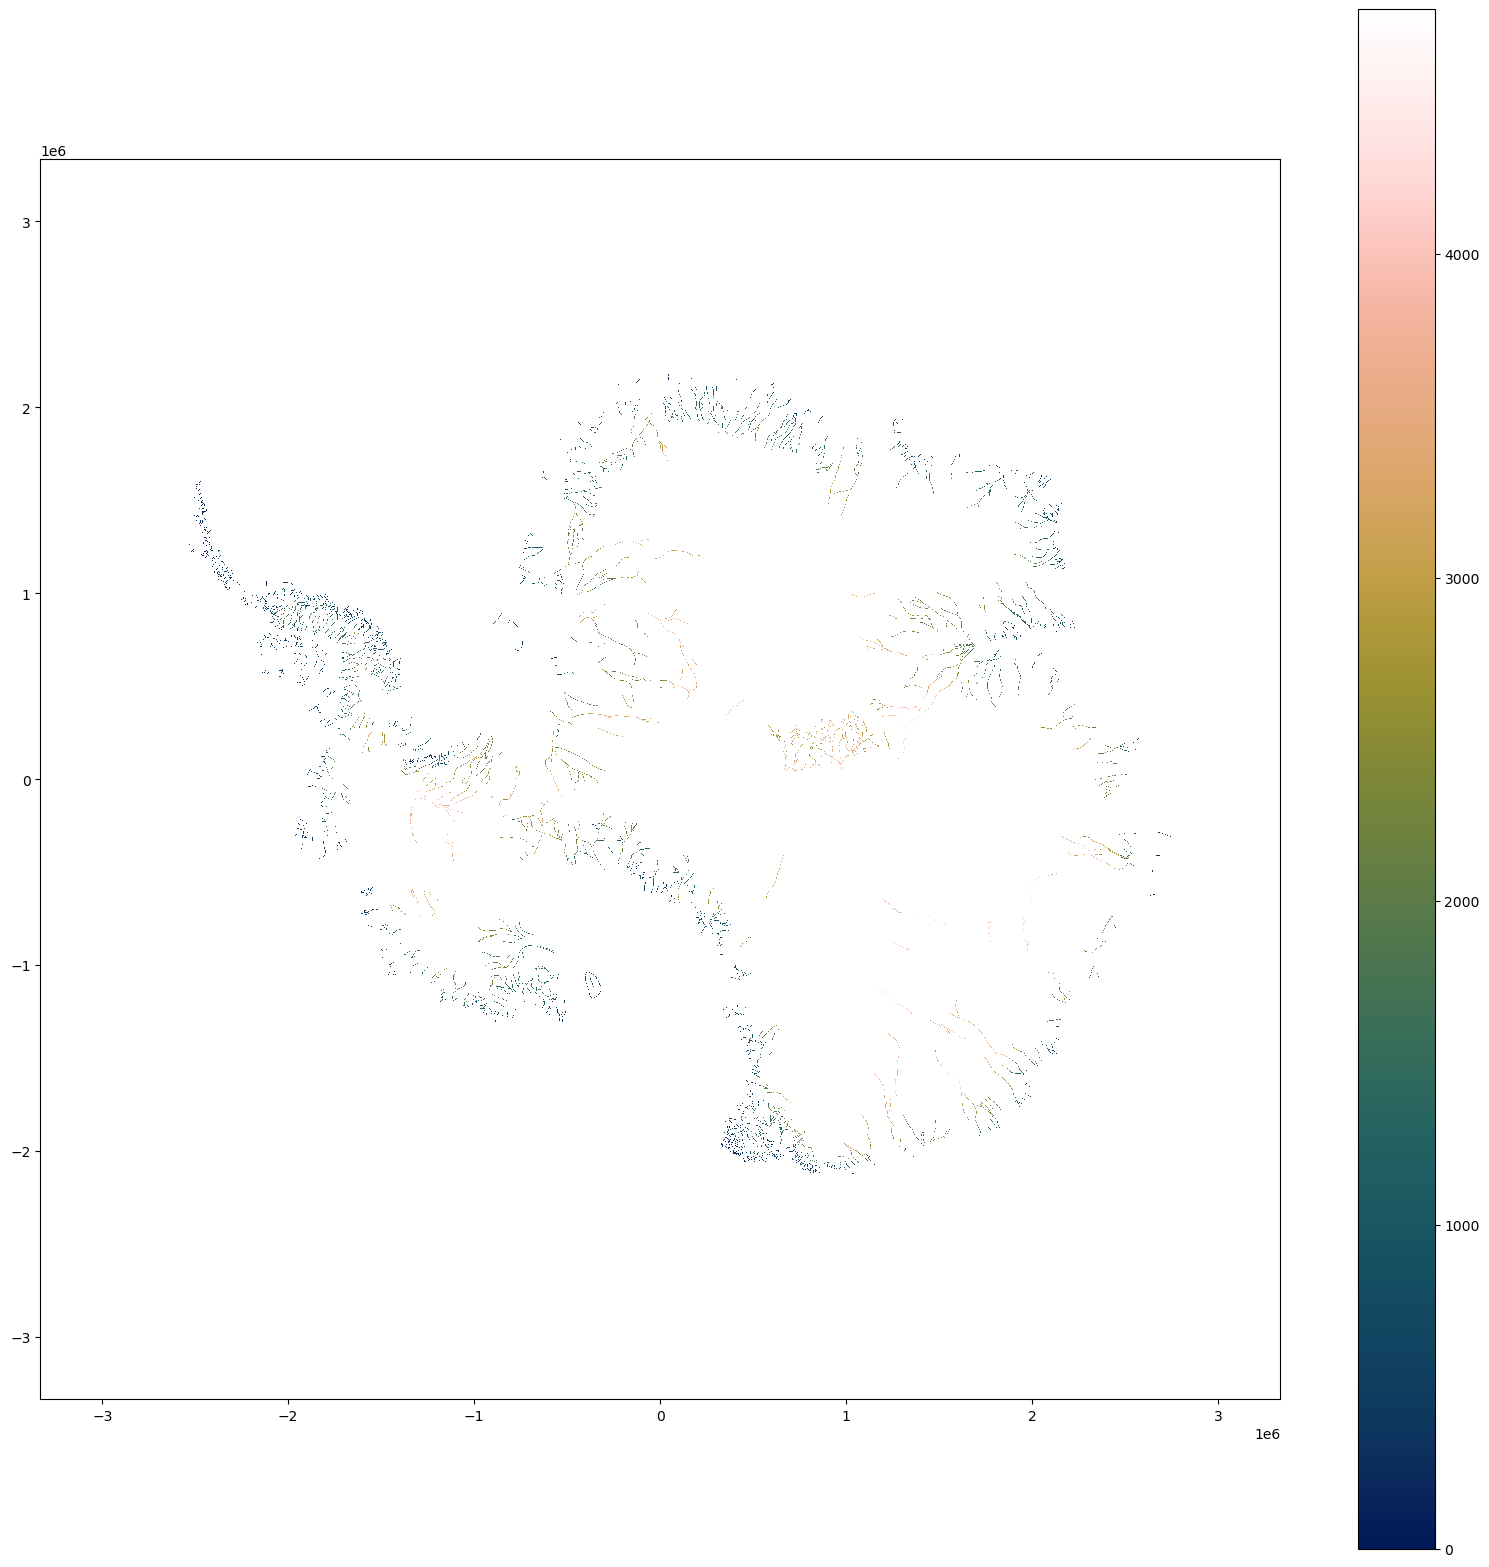

In [54]:
plt.figure(figsize=(20,20))
plt.pcolormesh(ds.x, ds.y, stream_thick, cmap=cm.batlowW)
plt.axis('scaled')
plt.colorbar()
plt.show()

In [49]:
np.count_nonzero(~np.isnan(ds.thick_cond) & ~np.isnan(stream_thick))

41541

In [50]:
np.count_nonzero(~np.isnan(stream_thick))

223547

In [51]:
np.count_nonzero(~np.isnan(ds.thick_cond))

2697885

In [70]:
new_thick_cond = np.where(np.isnan(stream_thick), ds.thick_cond.values, stream_thick)

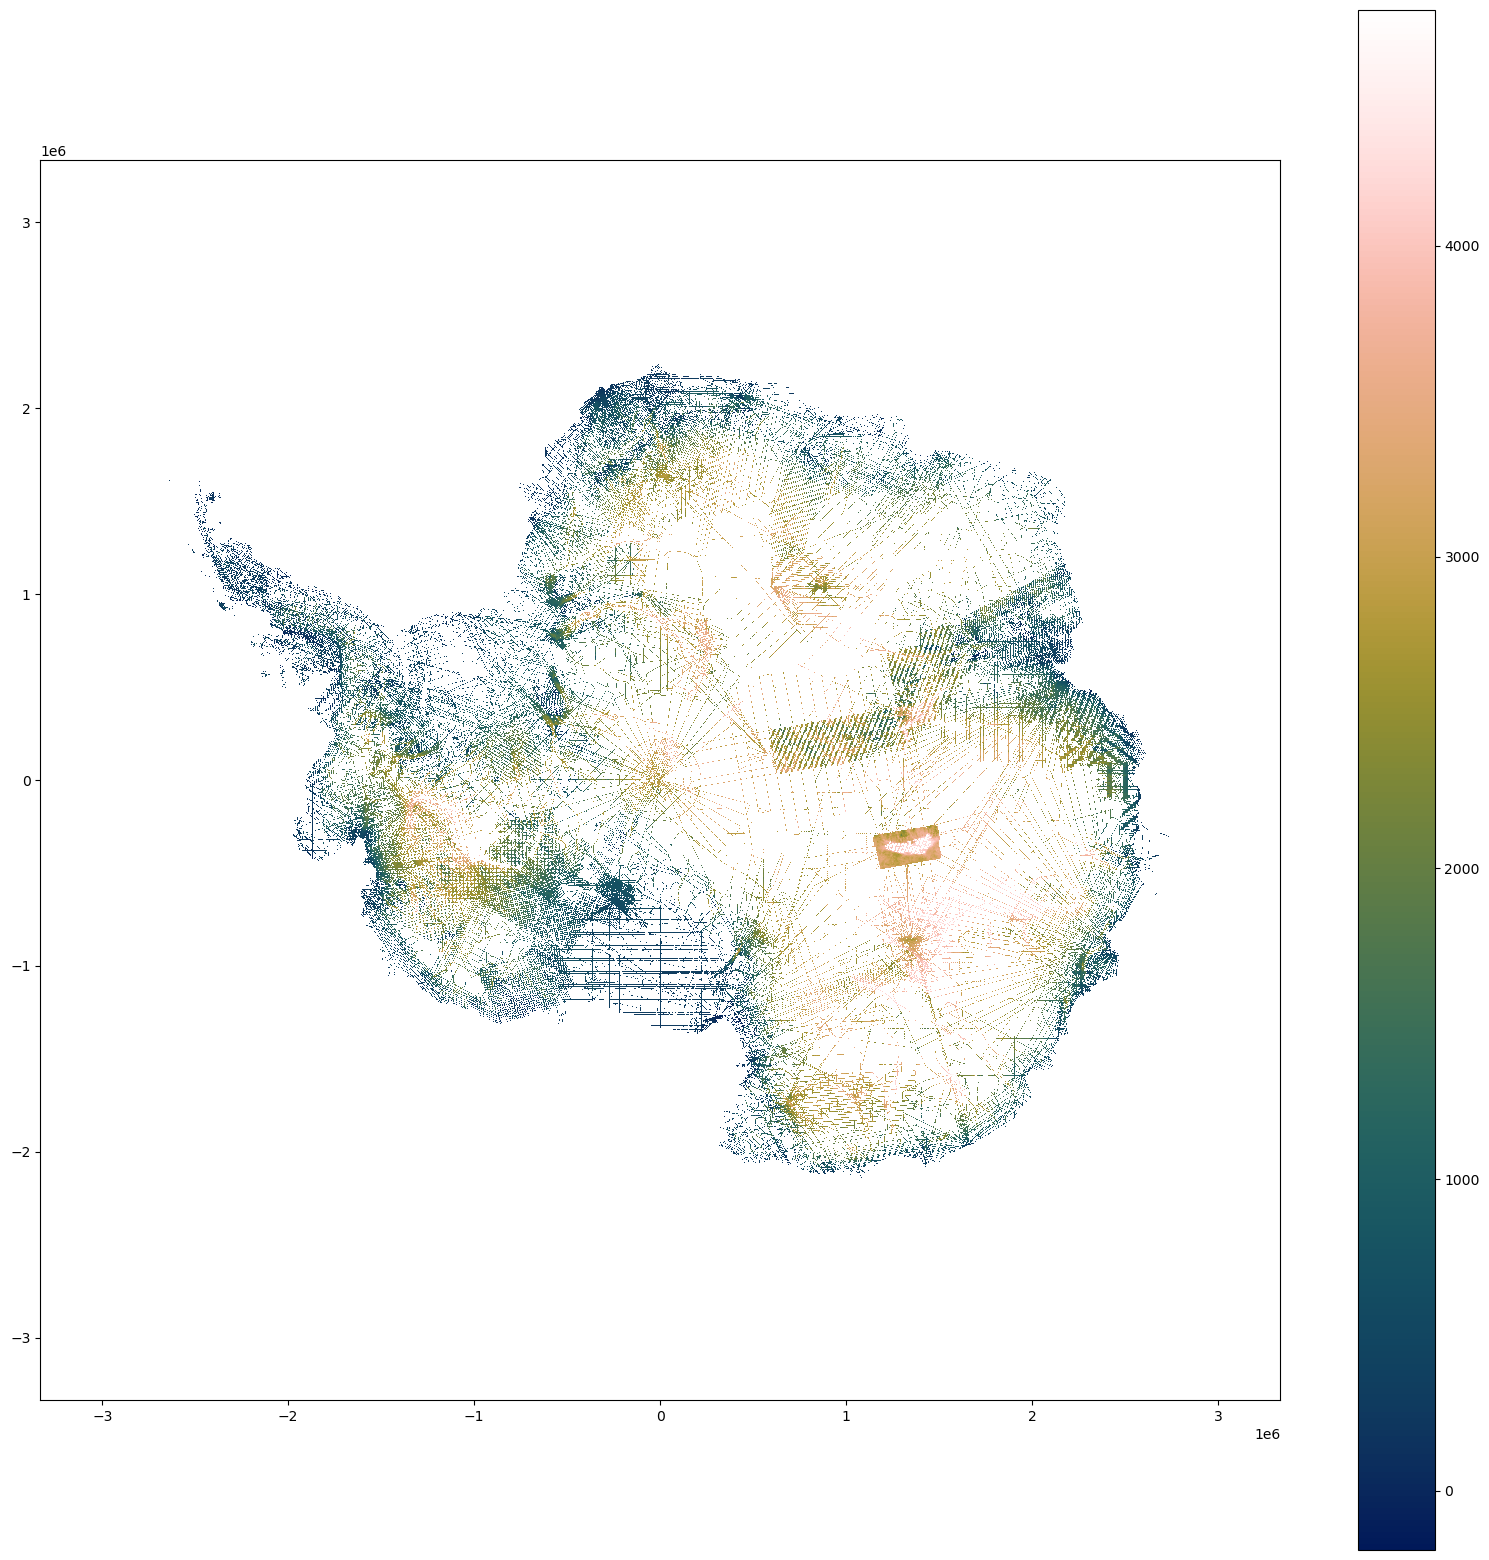

In [71]:
plt.figure(figsize=(20,20))
plt.pcolormesh(ds.x, ds.y, new_thick_cond, cmap=cm.batlowW)
plt.axis('scaled')
plt.colorbar()
plt.show()

In [66]:
ilow = 2800
ihigh = 3400
jlow = 3800
jhigh = 4900

xx_trim = xx[ilow:ihigh,jlow:jhigh]
yy_trim = yy[ilow:ihigh,jlow:jhigh]
thick_trim = new_thick_cond[ilow:ihigh,jlow:jhigh]

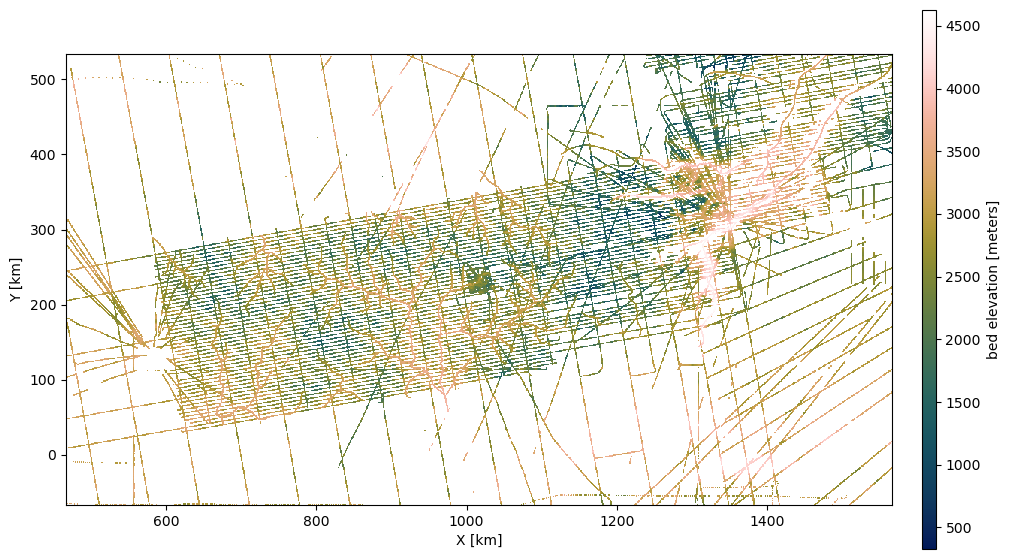

In [67]:
plt.figure(figsize=(13,10))
im = plt.pcolormesh(xx_trim/1000, yy_trim/1000, thick_trim, cmap=cm.batlowW)
plt.axis('scaled')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
#plt.title('SGS simulation+trend, matern covariance, nonstationary, anisotropic')
plt.colorbar(im, pad=0.03, aspect=40, shrink=0.7, label='bed elevation [meters]')
plt.show()

In [2]:
ds = xr.open_dataset(Path('../../bedmap/bedmap3_mod_1km.nc'))

# add exposed bedrock to conditioning data
thick_cond = np.where(ds.mask == 4, 0, ds.thick_cond.values)

bed_cond = ds.surface_topography.values - thick_cond
ice_rock_msk = (ds.mask == 1) | (ds.mask == 4) | (ds.mask == 2)
bed_cond = np.where(ice_rock_msk, bed_cond, np.nan)
xx, yy = np.meshgrid(ds.x, ds.y)

cond_msk = ~np.isnan(bed_cond)

In [4]:
np.count_nonzero(np.isnan(bed_cond[cond_msk]))

0

In [5]:
ds.shape

AttributeError: 'Dataset' object has no attribute 'shape'

In [6]:
ds

<xarray.Dataset> Size: 3GB
Dimensions:                 (y: 6667, x: 6667)
Coordinates:
  * x                       (x) float32 27kB -3.333e+06 -3.332e+06 ... 3.333e+06
  * y                       (y) float32 27kB 3.333e+06 3.332e+06 ... -3.333e+06
Data variables: (12/13)
    surface_topography      (y, x) float32 178MB nan nan nan nan ... nan nan nan
    bed_uncertainty         (y, x) float32 178MB ...
    bed_topography          (y, x) float32 178MB ...
    mask                    (y, x) float64 356MB nan nan nan nan ... nan nan nan
    ice_thickness           (y, x) float32 178MB ...
    thickness_survey_count  (y, x) float32 178MB ...
    ...                      ...
    mapping                 <U19 76B ...
    geoid                   (y, x) float64 356MB ...
    bed_ell                 (y, x) float64 356MB ...
    surface_ell             (y, x) float64 356MB ...
    thick_cond              (y, x) float64 356MB nan nan nan nan ... nan nan nan
    trend                   (y, x) float64 356MB ...
Attributes: (12/26)
    crs:                    EPSG:3031
    title:                  BEDMAP3 - Ice thickness, bed and surface elevatio...
    summary:                We present here Bedmap3, the latest suite of grid...
    keywords:               Antarctica,BEDMAP,Elevation,Ice thickness
    Conventions:            ACDD-1.3, CF-1.8
    citation:               Pritchard, H., Fretwell, P., Fremand, A., Bodart,...
    ...                     ...
    time_coverage_end:      2024-11-01
    geospatial_lon_min:     -180
    geospatial_lon_max:     180
    geospatial_lat_min:     -90
    geospatial_lat_max:     -60
    geospatial_bounds_crs:  EPSG:4326

In [3]:
var = xr.open_dataset(Path('continental_variogram.nc'))
var

<xarray.Dataset> Size: 2GB
Dimensions:      (y: 6667, x: 6667)
Coordinates:
  * y            (y) float32 27kB 3.333e+06 3.332e+06 ... -3.332e+06 -3.333e+06
  * x            (x) float32 27kB -3.333e+06 -3.332e+06 ... 3.332e+06 3.333e+06
Data variables:
    varr         (y, x) float64 356MB ...
    ranges       (y, x) float64 356MB ...
    sill         (y, x) float64 356MB ...
    smooth       (y, x) float64 356MB ...
    major_range  (y, x) float64 356MB ...
    minor_range  (y, x) float64 356MB ...
    azimuth      (y, x) float64 356MB ...

In [4]:
var.major_range.isel(x=3329, y=5820).values

array(118570.92515184)

In [5]:
var.minor_range.isel(x=3329, y=5820).values

array(37367.0078125)

In [6]:
var.azimuth.isel(x=3329, y=5820).values

array(-112.83306885)

In [7]:
ice_rock_msk = (ds.mask == 1) | (ds.mask == 4) | (ds.mask == 2)

In [8]:
np.count_nonzero((ice_rock_msk==True) & np.isnan(var.major_range.values))

0

In [9]:
np.count_nonzero((ice_rock_msk==True) & np.isnan(var.minor_range.values))

0

In [10]:
np.count_nonzero((ice_rock_msk==True) & np.isnan(var.azimuth.values))

0

In [13]:
import psutil
psutil.cpu_count(logical=False)

8

In [15]:
import numbers
isinstance(np.array([np.nan, np.nan]), numbers.Number)

False

In [16]:
tmp = None

isinstance(tmp, None)

TypeError: isinstance() arg 2 must be a type, a tuple of types, or a union

In [17]:
nc_path = Path('../continental_variogram.nc')


In [22]:
nc_path.

ValueError: relative path can't be expressed as a file URI